In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
train_dataset = torchvision.datasets.MNIST(root='/Users/ekinokos2/datasets/MNIST', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='/Users/ekinokos2/datasets/MNIST', train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
criterion = nn.CrossEntropyLoss()  # Logistic loss

# Kaiming Initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)

## Gradient Descent (GD)

In [7]:
# Training loop
def train_and_test(model, optimizer, criterion, train_loader, test_loader, epochs, learning_rate):
    model.train()
    optimizer.param_groups[0]['lr'] = learning_rate  # Set the learning rate
    training_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        training_losses.append(running_loss / len(train_loader))
    accuracy = test(model, test_loader)
    return training_losses, accuracy

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

Optimizer: Batch GD, Learning Rate: 0.001, Accuracy: 98.86
Optimizer: Batch GD, Learning Rate: 0.01, Accuracy: 98.55
Optimizer: Batch GD, Learning Rate: 0.1, Accuracy: 9.8


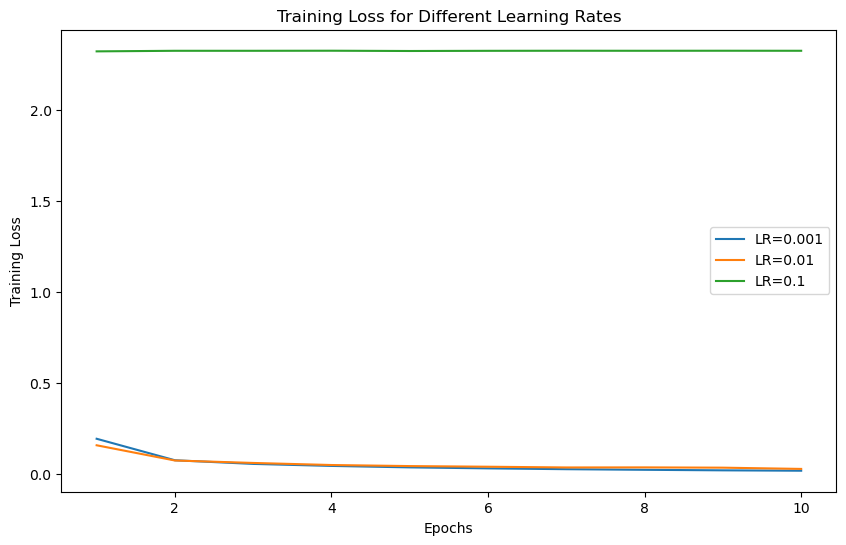

Accuracy for LR=0.001: 98.86%
Accuracy for LR=0.01: 98.55%
Accuracy for LR=0.1: 9.80%


In [12]:
# Define different learning rates to try
learning_rates = [0.001, 0.01, 0.1]

train_loader = torch.utils.data.DataLoader(train_dataset,  shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,  shuffle=False)

gd_results = {}
for lr in learning_rates:
    gd_model = LeNet()
    gd_optimizer = optim.SGD(gd_model.parameters(), lr=lr) # GD
    
    gd_model.apply(weights_init)
    training_losses, accuracy = train_and_test(gd_model, gd_optimizer, criterion, train_loader, test_loader, epochs=10, learning_rate=lr)
    print("Optimizer: Batch GD, Learning Rate: {}, Accuracy: {}".format(lr, accuracy))
    gd_results[(lr)] = (training_losses, accuracy)

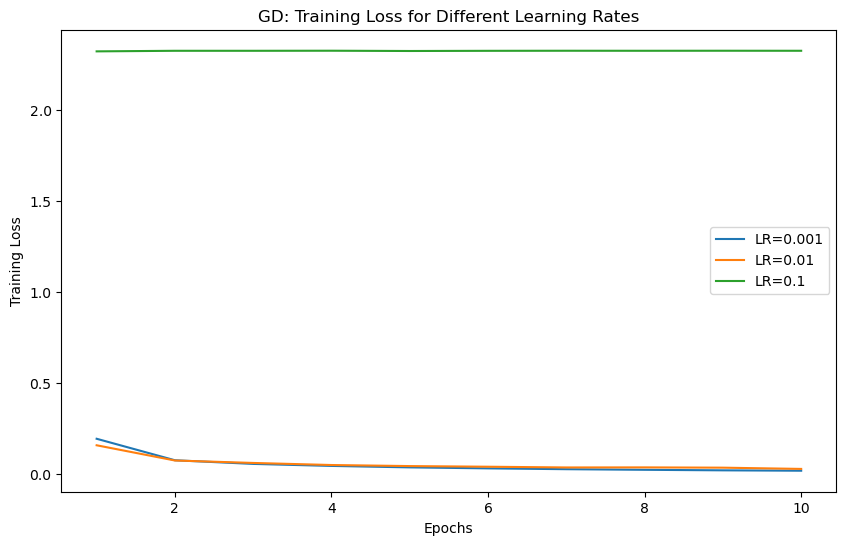

Accuracy for LR=0.001: 98.86%
Accuracy for LR=0.01: 98.55%
Accuracy for LR=0.1: 9.80%


In [15]:
# Plot the training losses for different learning rates
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    losses, _ = gd_results[lr]
    plt.plot(range(1, 11), losses, label=f'LR={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('GD: Training Loss for Different Learning Rates')
plt.show()

# Print accuracy results for different learning rates
for lr, (_, accuracy) in gd_results.items():
    print(f'Accuracy for LR={lr}: {accuracy:.2f}%')

## Stochastic Gradient Descent (SGD)

Optimizer: Batch GD, Learning Rate: 0.001, Accuracy: 94.9
Optimizer: Batch GD, Learning Rate: 0.01, Accuracy: 98.11
Optimizer: Batch GD, Learning Rate: 0.1, Accuracy: 98.84


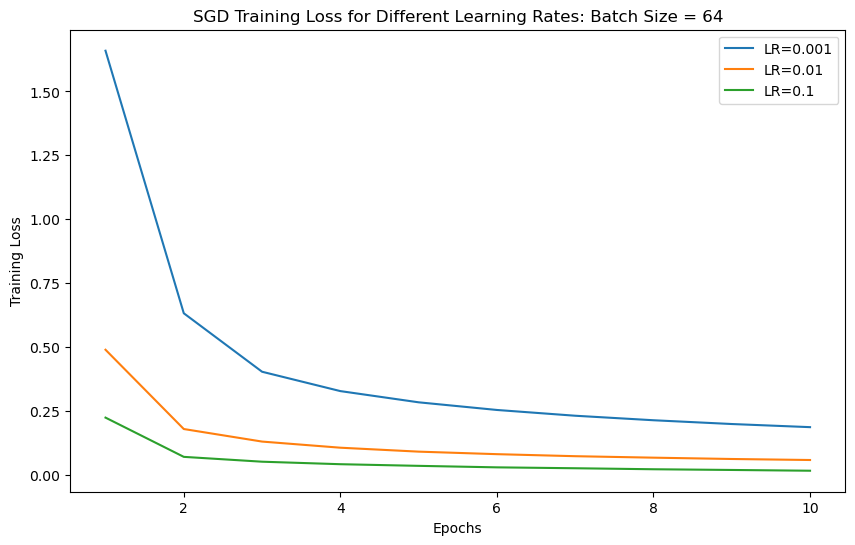

Optimizer: Batch GD, Learning Rate: 0.001, Accuracy: 92.55
Optimizer: Batch GD, Learning Rate: 0.01, Accuracy: 97.31
Optimizer: Batch GD, Learning Rate: 0.1, Accuracy: 98.77


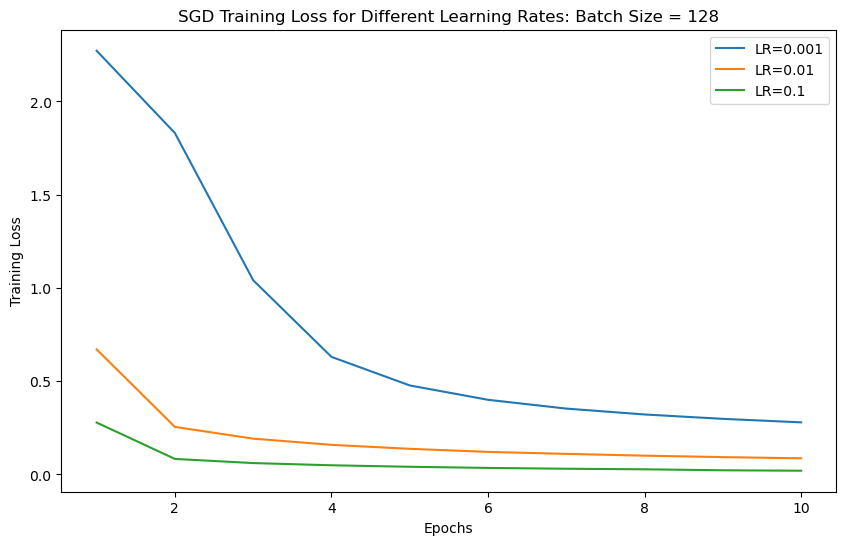

In [16]:
# Fix two different batch sizes for SGD, partition the training set into
# batches, and train the model for 10 epochs for each batch size
sgd_results_64 = {}
sgd_results_128 = {}

train_loader_64 = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_128 = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

for lr in learning_rates:
    sgd_model_64 = LeNet()
    sgd_optimizer = optim.SGD(sgd_model_64.parameters(), lr=lr) # SGD
    
    sgd_model_64.apply(weights_init)
    training_losses, accuracy = train_and_test(sgd_model_64, sgd_optimizer, criterion, train_loader_64, test_loader, epochs=10, learning_rate=lr)
    print("Optimizer: Batch GD, Learning Rate: {}, Accuracy: {}".format(lr, accuracy))
    sgd_results_64[(lr)] = (training_losses, accuracy)

# Plot the training losses for different learning rates
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    losses, _ = sgd_results_64[lr]
    plt.plot(range(1, 11), losses, label=f'LR={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('SGD Training Loss for Different Learning Rates: Batch Size = 64')
plt.show()

for lr in learning_rates:
    sgd_model_128 = LeNet()
    sgd_optimizer = optim.SGD(sgd_model_128.parameters(), lr=lr) # SGD
    
    sgd_model_128.apply(weights_init)
    training_losses, accuracy = train_and_test(sgd_model_128, sgd_optimizer, criterion, train_loader_128, test_loader, epochs=10, learning_rate=lr)
    print("Optimizer: Batch GD, Learning Rate: {}, Accuracy: {}".format(lr, accuracy))
    sgd_results_128[(lr)] = (training_losses, accuracy)

# Plot the training losses for different learning rates
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    losses, _ = sgd_results_128[lr]
    plt.plot(range(1, 11), losses, label=f'LR={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('SGD Training Loss for Different Learning Rates: Batch Size = 128')
plt.legend()

## AdaGrad

In [18]:
ada_results = {}

# AdaGrad
initial_accumulator = 0.0

# Define different learning rates to try
learning_rates = [0.001, 0.01, 0.1]

# Define different learning rate decay values (for AdaGrad)
lr_decays = [0.001, 0.01, 0.1]

# Fix batch size
train_loader_128 = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

for lr in learning_rates:
    for lr_decay in lr_decays:
        ada_model = LeNet()
        ada_optimizer = optim.Adagrad(ada_model.parameters(), lr=lr, lr_decay=lr_decay, initial_accumulator_value=initial_accumulator)
        ada_model.apply(weights_init)
        training_losses, accuracy = train_and_test(ada_model,ada_optimizer, criterion, train_loader_128, test_loader, epochs=10, learning_rate=lr)
        print("Optimizer: AdaGrad, Learning Rate: {}, Learning Rate Decay: {}, Accuracy: {}".format(lr, lr_decay, accuracy))
        ada_results[(lr, lr_decay)] = (training_losses, accuracy)

Optimizer: AdaGrad, Learning Rate: 0.001, Learning Rate Decay: 0.001, Accuracy: 94.49
Optimizer: AdaGrad, Learning Rate: 0.001, Learning Rate Decay: 0.01, Accuracy: 86.13
Optimizer: AdaGrad, Learning Rate: 0.001, Learning Rate Decay: 0.1, Accuracy: 54.01
Optimizer: AdaGrad, Learning Rate: 0.01, Learning Rate Decay: 0.001, Accuracy: 98.16
Optimizer: AdaGrad, Learning Rate: 0.01, Learning Rate Decay: 0.01, Accuracy: 97.16
Optimizer: AdaGrad, Learning Rate: 0.01, Learning Rate Decay: 0.1, Accuracy: 92.93
Optimizer: AdaGrad, Learning Rate: 0.1, Learning Rate Decay: 0.001, Accuracy: 97.3
Optimizer: AdaGrad, Learning Rate: 0.1, Learning Rate Decay: 0.01, Accuracy: 95.9
Optimizer: AdaGrad, Learning Rate: 0.1, Learning Rate Decay: 0.1, Accuracy: 84.6


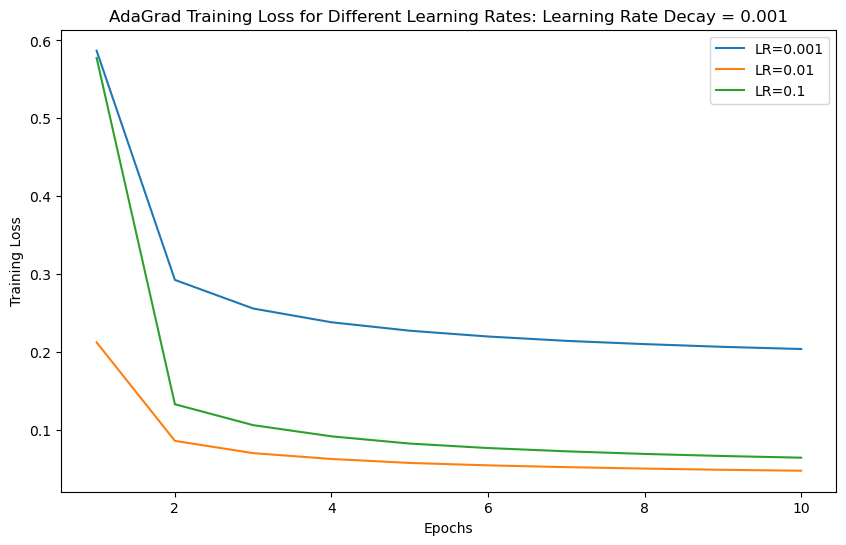

In [19]:
# Get all results for learning_decay = 0.001
plt.figure(figsize=(10, 6))
for lr, lr_decay in list(ada_results.keys()):
    if lr_decay == 0.001:
        losses, _ = ada_results[(lr, lr_decay)]
        plt.plot(range(1, 11), losses, label=f'LR={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('AdaGrad Training Loss for Different Learning Rates: Learning Rate Decay = 0.001')
plt.legend()

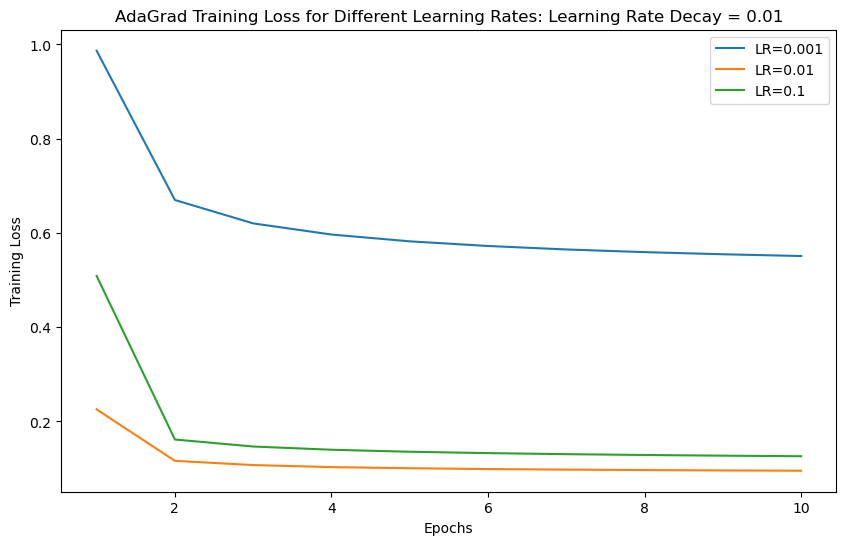

In [20]:
# Get all results for learning_decay = 0.01
plt.figure(figsize=(10, 6))
for lr, lr_decay in list(ada_results.keys()):
    if lr_decay == 0.01:
        losses, _ = ada_results[(lr, lr_decay)]
        plt.plot(range(1, 11), losses, label=f'LR={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('AdaGrad Training Loss for Different Learning Rates: Learning Rate Decay = 0.01')
plt.legend()

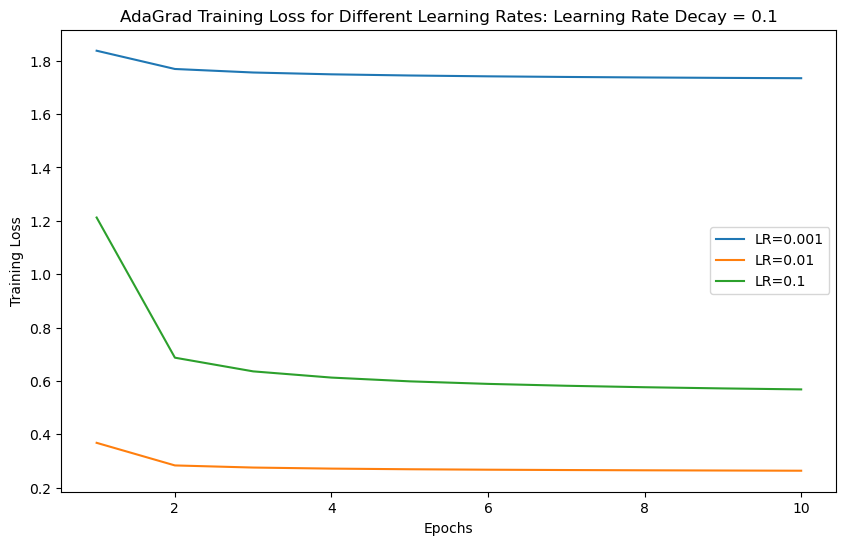

In [21]:
# Get all results for learning_decay = 0.1
plt.figure(figsize=(10, 6))
for lr, lr_decay in list(ada_results.keys()):
    if lr_decay == 0.1:
        losses, _ = ada_results[(lr, lr_decay)]
        plt.plot(range(1, 11), losses, label=f'LR={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('AdaGrad Training Loss for Different Learning Rates: Learning Rate Decay = 0.1')
plt.legend()

## Adam

In [35]:
# Define three different values for adaptivity momentum (for Adam)
momentums = [0.9, 0.5, 0.1]

# Define three different values for gradient momentum (for Adam)
grad_momentums = [0.999, 0.555, 0.1]

# Fix batch size
train_loader_256 = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# Fix a learning rate
lr = 0.001

adam_results = {}

for momentum in momentums:
    for grad_momentum in grad_momentums:
        adam_model = LeNet()
        adam_optimizer = optim.Adam(adam_model.parameters(), lr=lr, betas=(momentum, grad_momentum))
        adam_model.apply(weights_init)
        training_losses, accuracy = train_and_test(adam_model, adam_optimizer, criterion, train_loader_256, test_loader, epochs=10, learning_rate=lr)
        print("Optimizer: Adam, Learning Rate: {}, Momentum: {}, Gradient Momentum: {}, Accuracy: {}".format(lr, momentum, grad_momentum, accuracy))
        adam_results[(momentum, grad_momentum)] = (training_losses, accuracy)

Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.9, Gradient Momentum: 0.999, Accuracy: 98.58
Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.9, Gradient Momentum: 0.555, Accuracy: 97.07
Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.9, Gradient Momentum: 0.1, Accuracy: 9.8
Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.5, Gradient Momentum: 0.999, Accuracy: 98.64
Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.5, Gradient Momentum: 0.555, Accuracy: 98.79
Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.5, Gradient Momentum: 0.1, Accuracy: 98.65
Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.1, Gradient Momentum: 0.999, Accuracy: 98.71
Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.1, Gradient Momentum: 0.555, Accuracy: 98.52
Optimizer: Adam, Learning Rate: 0.001, Momentum: 0.1, Gradient Momentum: 0.1, Accuracy: 98.69


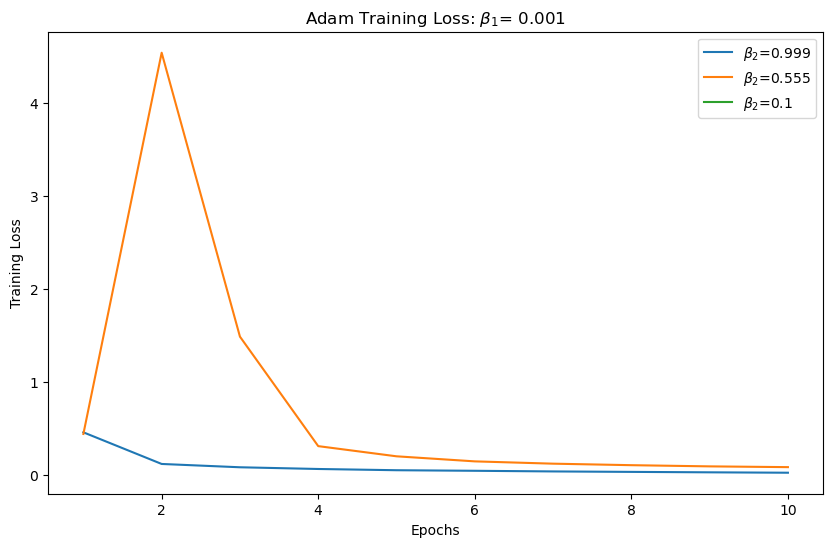

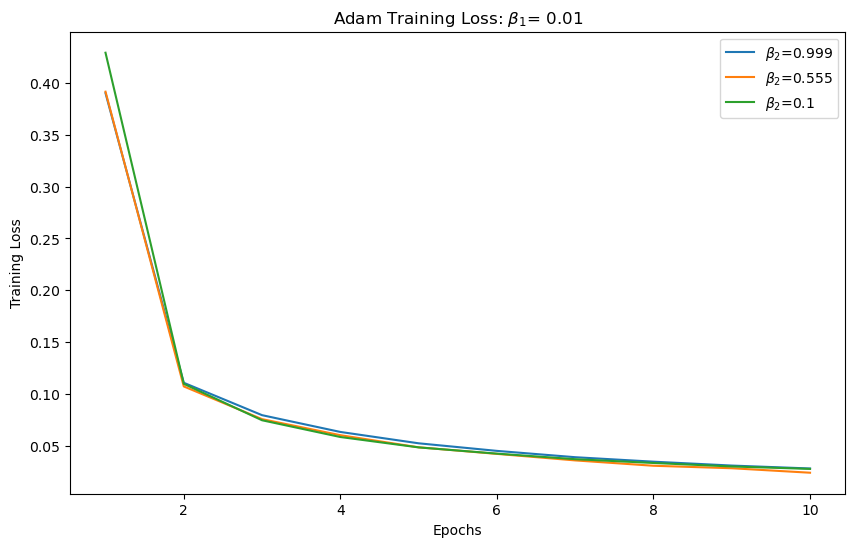

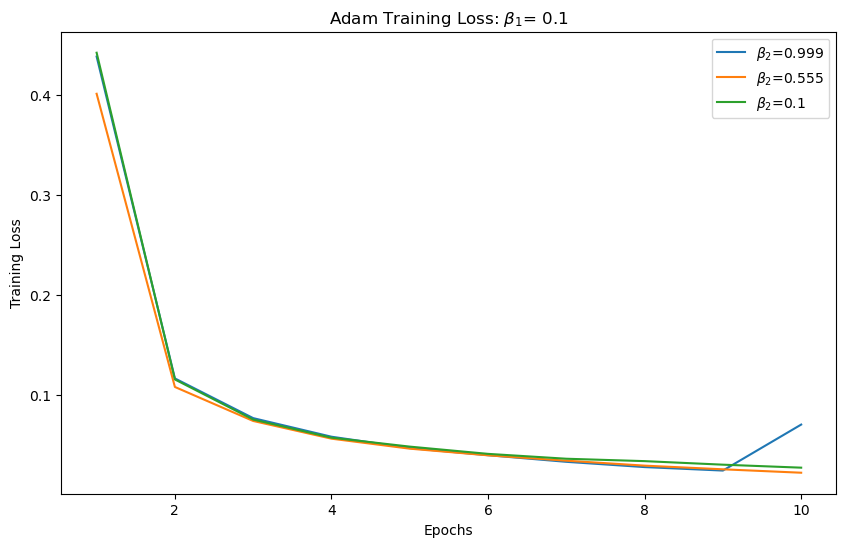

In [37]:
# Get all results for momentum = 0.001
plt.figure(figsize=(10, 6))
for momentum, grad_momentum in list(adam_results.keys()):
    if momentum == 0.9:
        losses, _ = adam_results[(momentum, grad_momentum)]
        plt.plot(range(1, 11), losses, label=r'$\beta_2$=' + str(grad_momentum))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Adam Training Loss: ' + r'$\beta_1$' + '= 0.001')
plt.legend()

# Get all results for momentum = 0.01
plt.figure(figsize=(10, 6))
for momentum, grad_momentum in list(adam_results.keys()):
    if momentum == 0.5:
        losses, _ = adam_results[(momentum, grad_momentum)]
        plt.plot(range(1, 11), losses, label=r'$\beta_2$=' + str(grad_momentum))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Adam Training Loss: ' + r'$\beta_1$' + '= 0.01')
plt.legend()

# Get all results for momentum = 0.1
plt.figure(figsize=(10, 6))
for momentum, grad_momentum in list(adam_results.keys()):
    if momentum == 0.1:
        losses, _ = adam_results[(momentum, grad_momentum)]
        plt.plot(range(1, 11), losses, label=r'$\beta_2$=' + str(grad_momentum))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Adam Training Loss: ' + r'$\beta_1$' + '= 0.1')
plt.legend()

